In [28]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# Step 1. Naive simulation.
- Simulate N bodies
- There's a transmission rate 
- At each time step, all the infected people have some *transmission rate* probability of infecting everyone.
- Just tracking rate of *infection* through. Don't worry about death.
- 0 dimensional problem

In [106]:
# 1 is healthy. 0 is not.
def infect(df, trans_rate, day_name): # need to speed up
    """
    Simulates a single day of infection. Each infected person
    
    NOTE: a 0 counts as infected, while a 1 is healthy.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        day_name : (float or int) the day of this infection, used to create a new
                        column in the dataframe tracking the day's infections.
                        
    Outputs:
        df : (pandas DataFrame) object, same as the input, but with a new column
                        holding this day's infected results.
    """
    p = 1 - trans_rate # to confer correct healthy/sick convention.
    for i in range(len(df)):
        if df['infected'][i] == 0.0: # if infected, infect others
            infect_col = np.random.binomial(size=len(df), p=p, n=1) # 1 toss, siz
            
            # next, create a new column to track this day's number of infected individuals
            df[f"infected day {day_name}"] = df[f"infected day {day_name - 1}"] * infect_col
    return df

def simulate(N, trans_rate, t_steps, N_initial):
    """
    Simulates an infection run.
    
    Inputs:
        N : (int) number of individuals in the system.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        t_steps : (int) number of time steps ("days") to consider.
        N_initial : (int) number of initially infected individuals.
        
    Outputs:
         df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. 
    """
    # making separate name column because indices get messy. 
    # other cols later.
    d = {'name': np.arange(N), 'infected day 0': np.ones(N)} 

    df = pd.DataFrame(data=d)
    
    df.loc[:N_initial, 'infected'] = 0 # Make first N_initial people sick 
    t = 1
    while t < t_steps:
        df = infect(df, trans_rate, t)
        t += 1
    return df
        

In [107]:
%%time
df = simulate(100000, .1, 30, 1)

CPU times: user 58.4 s, sys: 280 ms, total: 58.7 s
Wall time: 59.6 s


In [108]:
df.columns

Index(['name', 'infected day 0', 'infected', 'infected day 1',
       'infected day 2', 'infected day 3', 'infected day 4', 'infected day 5',
       'infected day 6', 'infected day 7', 'infected day 8', 'infected day 9',
       'infected day 10', 'infected day 11', 'infected day 12',
       'infected day 13', 'infected day 14', 'infected day 15',
       'infected day 16', 'infected day 17', 'infected day 18',
       'infected day 19', 'infected day 20', 'infected day 21',
       'infected day 22', 'infected day 23', 'infected day 24',
       'infected day 25', 'infected day 26', 'infected day 27',
       'infected day 28', 'infected day 29'],
      dtype='object')

Text(0, 0.5, 'Number of infected individuals')

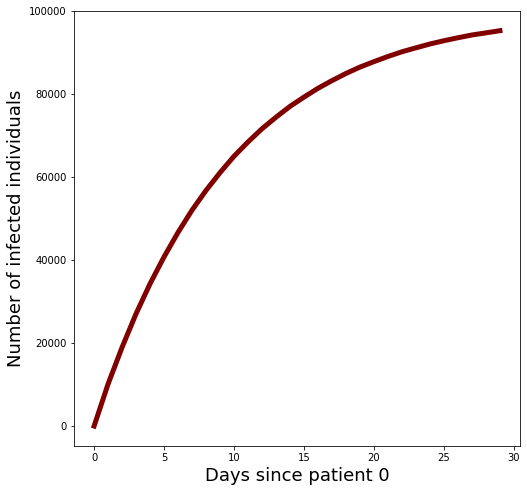

In [115]:
plt.figure(figsize=(8,8))
infections = np.array([df[col].sum() for col in df.columns if 'infected day' in col])
plt.plot(np.arange(len(infections)), 100000 - infections, lw=5, color='maroon')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')

In [97]:
infections

array([1.000e+05, 0.000e+00, 9.987e+03, 9.960e+02, 1.000e+02, 6.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00])

# Step 2. 1D simulation
- Same as before, but now accounting for *distance* between people
- a distance factor, within some certain range, is multiplied to base transmission factor
- randomly initialize the N bodies around the origin

In [120]:
pd.core.frame.DataFrame


pandas.core.frame.DataFrame

In [118]:
type(df)

pandas.core.frame.DataFrame

In [116]:
def distance_multiplier(df, row1, row2, thresh, power):
    """
    returns a distance multiplier based on two individuals, to be smacked 
    onto the transmission rate, that is always less than 1. 
    
    if the metric distance (defined within) is below thresh, multiplier of 1.
    Anything greater falls off as distance to the power law. Power is some law greater than 0.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                            column of "infected day _" corresponds to a different day, 
                            with "_" being some integer or float. The "name" column
                            assigns a name to each object, independent of index. In
                            the infected columns, a 0 counts as infected, while a 1 is 
                            healthy.
        row1 : (int) Greater than 0. Row of the first individual in the distance calculation.
        row2 : (int) Greater than 0. Row of the second individual in the distance calculation.
        thresh : (float) distance less than which infection is transmitted at the trans_rate;
                            that is, less than which this function returns a value of 1. At
                            a distance greater than this, this function returns 1/distance^power.
        power : (float) Greater than 0. Power to which the multiplier falls off if the distance
                            is greater than some threshold.
    
    Outputs:
        multiplier : (float) suppresses the rate of transmission.
    """
    # first check input types
    if type(thresh) != int and type(thresh) != float:
        raise AssertionError("wrong type for thresh.")
    if type(df) != pd.core.frame.DataFrame:
        raise AssertionError("df must be a pandas DataFrame.")
    if type(row1) != int:
        raise AssertionError("row1 must be an integer.")
    if type(row2) != int:
        raise AssertionError("row2 must be an integer.")
    if type(power) != float and type(power) != int:
        raise AssertionError("power must be a float or integer.")
    
        
    # first check input values
    if thresh <= 0:
        raise AssertionError("thresh must be positive.")
    if row1 <= 0:
        raise AssertionError("row1 must be positive.")
    if row2 <= 0:
        raise AssertionError("row2 must be positive.")
    if power <= 0:
        raise AssertionError("power must be positive.")
        
        
    def metric_distance(r1, r2):
        return abs(r1 - r2)
    r1, r2 = df['r'][row1], df['r'][row2]
    dist = metric_distance(r1, r2)
    if dist < thresh:
        return 1.
    else:
        return 1/pow(dist, power)
